In [163]:
with open("input.txt", encoding='utf-8') as f:
    text = f.read()

vocab_size = len(set(text))

In [164]:
encoder_map = {c: i for i, c in enumerate(set(text))}
decoder_map = {i: c for i, c in enumerate(set(text))}

encode = lambda x: [encoder_map[c] for c in x]
decode = lambda x: ''.join([decoder_map[i] for i in x])

In [165]:
encode("Test string"), decode(encode("Test string"))

([51, 31, 28, 30, 45, 28, 30, 18, 52, 63, 8], 'Test string')

In [166]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
data[:25]

tensor([56, 52, 18, 28, 30, 45, 34, 52, 30, 52, 22, 31, 63, 17, 12, 46, 31, 10,
         7, 18, 31, 45, 39, 31, 45])

In [167]:
split = int(len(data) * 0.8)
train_data, val_data = data[:split], data[split:]

In [168]:
torch.manual_seed(2115)
batch_size = 4
seq_len = 8
n_embed = 32


def get_batches(mode):
    bath_data = train_data if mode == 'train' else val_data
    idx = torch.randint(0, len(bath_data) - seq_len, (batch_size,))
    x = torch.stack([bath_data[i:i + seq_len] for i in idx])
    y = torch.stack([bath_data[i + 1:i + seq_len + 1] for i in idx])
    return x, y


xb, yb = get_batches('train')

In [169]:
import torch.nn as nn
from torch.nn import functional as F


class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))
        self.head_size = head_size

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        weights = q @ k.transpose(-1, -2) * C ** -0.5
        weights = weights.masked_fill(self.tril[:T, : T] == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        return weights @ v

In [170]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(seq_len, n_embed)
        self.sa_head = Head(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        token_embedding = self.token_embedding_table(idx)
        position_embedding = self.position_embedding_table(torch.arange(T))
        x = token_embedding + position_embedding
        x = self.sa_head(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, n):
        for _ in range(n):
            idx_crop = idx[:, -seq_len:]
            logits, _ = self(idx_crop)
            logits = logits[:, -1, :]
            p = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(p, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx

In [171]:
m = BigramLanguageModel()

In [172]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batches(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [173]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

batch_size = 32
history = []
eval_interval = 200
max_iter = 2000
for iter in range(max_iter):

    if iter % eval_interval == 0:
        losses = estimate_loss(m)
        history.append((iter, losses))

    x, y = get_batches('train')
    logits, loss = m(x, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

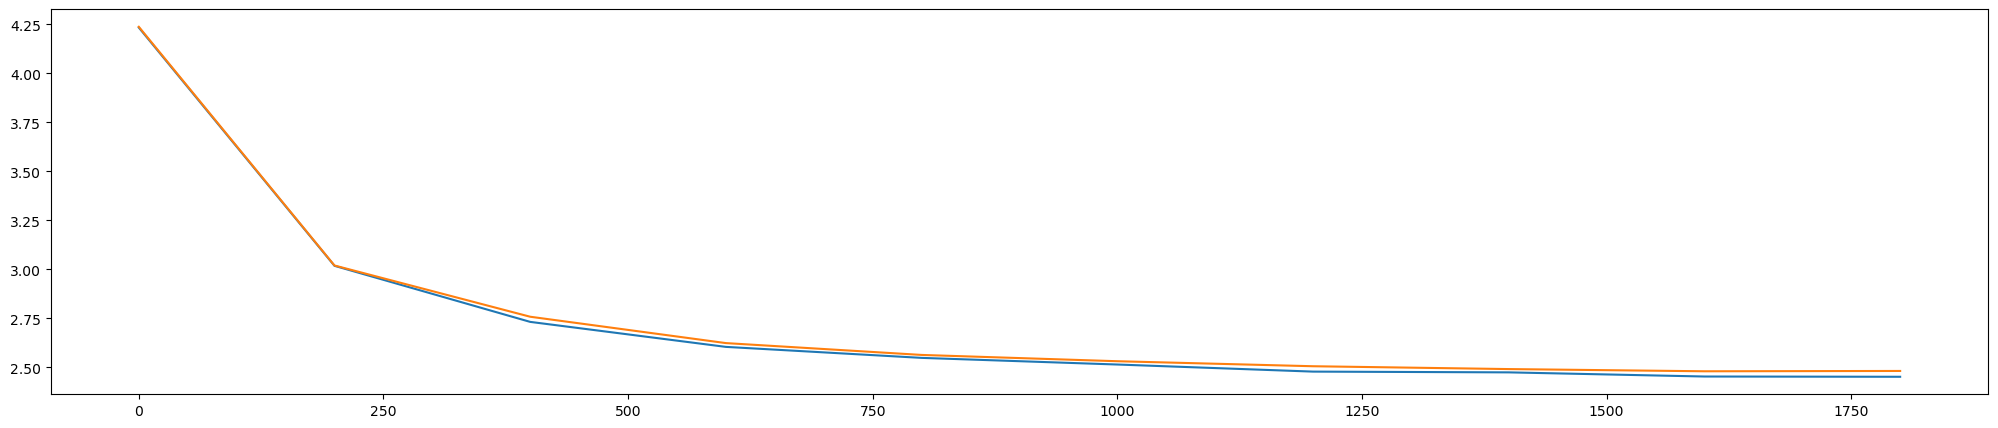

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 5))

x = [h[0] for h in history]
y = [h[1]['train'] for h in history]    
y_val = [h[1]['val'] for h in history]
plt.plot(x, y, label='train')
plt.plot(x, y_val, label='val')

In [175]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(idx, 1000)[0].tolist()))

qily thane owurr mo that hat wel nmo! nol nove st oitoo peneren
O'dloun poerplagemos ay hiss itaveevell blou dofoury theamy I felvyearsoif rl'dd al artoo thepess ate thellife me anderes hisht,
A:
A
Pindebe is, my weam fere
ALAper cout oucen wet htbeexro, h-ele, wo woke,
Aleailanr den
W:

rle, hy gheele ng oreBeas hfiseere'gor adps's?

GESd
BPy yameeit hoemome tas aver guspads ke.
Ming Per ole.  dou cte nig bavemabught cosyome che mar thoo thou'd:
Wut, thevevefant my tad to se! tcis
is ft nigealsh hE;
N:
ARTheir lok de chivoirt,
Fou, yow morods th,
WWases.

G:
CING:
Yer, o se geatqio warach:
Wale'd:
A thean qua wh'stwen
Go ree, whe al.

Py his fitcuthead nd mecsis I olokulsecut soo hicotures lagr savaldier thaghe arbliths, the sphe ts mormecomo ut pt hadt der to; of orus, Mben cer:
Soul vaf dis Son dseeer toalncen hithme
Ar hancotpord hot:
Foofot e shy motel cad iceawt fha imo kmyoo tha be
CI hli aghis dlarm, ndr-y gy kly moungd ang dk-m icuchf le sato dfoous whand Tonk thermy, hmy cay,